$\vec{v_{n}} = R^{B}_{n} \vec{v_{b}}$

$Re \left[eig (\frac{df}{dx})|_{x^{*}} \right] < 0$

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using StaticArrays
using TrajectoryOptimization
using Altro
using RobotDynamics
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations
using FileIO
using JLD2

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`


# Questions
### 1) How do I separate the J matrix for the flywheels and the body? 
### 2) Regarding part 1, where does the mass of the of the wheel factor in?
### 3) It's kinda weird that p is the state and \dot{p} is the control. Is that supposed to happen?

## Quadruped with a backpack

The quadruped with a quadruped is composed of four 3D hoppers, which were described in a prior example. Because each of the hopper's forces affect the body, we sum up the forces of each hopper's head in order to get the total forces on the body. Each hopper is assumed to be a prismatic joint and two revolute joints, allowing for yaw control of the foot. It makes the assumption that torque effects are equal and opposite at the head and foot. An image is shown below (copy that image in when you have time). It is parameterized by the following:  

$$ s = \begin{bmatrix} 
        \overrightarrow{r}_{body} \\
        \overrightarrow{q}_{body} \\
        \overrightarrow{r}_{f1} \\
        \overrightarrow{r}_{f2} \\
        \overrightarrow{r}_{f3} \\
        \overrightarrow{r}_{f4} \\
        \overrightarrow{p} \\
       \end{bmatrix} $$

where 
$$ \overrightarrow{r}_{body}  = \begin{bmatrix} 
                                  x_{body} \\
                                  y_{body} \\
                                  z_{body} \\
                                  \end{bmatrix}, \overrightarrow{q}_{body} = \begin{bmatrix} 
                                      q_{s} \\
                                      q_{x} \\
                                      q_{y} \\
                                      q_{z} \\
                                  \end{bmatrix}, \overrightarrow{r}_{fn}  = \begin{bmatrix} 
                                  x_{fn} \\
                                  y_{fn} \\
                                  z_{fn} \\
                                \end{bmatrix}, \overrightarrow{p}  = \begin{bmatrix} 
                                  p_{x} \\
                                  p_{y} \\
                                  p_{z} \\
                                \end{bmatrix} $$
                         
Note that to account for the 3D rigid body orientation of the quadruped's body, we use a quaternion state. However, because the motion is always in 3D, we transform it back to 3 dimensions when calculating $\omega$. The details of the calculations can be found in the [Planning with Attitude](https://roboticexplorationlab.org/papers/planning_with_attitude.pdf) paper published by the REx Lab. For the dynamics, we refer to Section 2 of the paper for the following on rigid body dynamics:

$$ \dot{q} = \frac{1}{2}L(q)H\omega$$
$$L(q) = \begin{bmatrix} q_{s} & -q_{v}^{T} \\ q_{v} & q_{s}I + [q_{v}]^{\times} \end{bmatrix}$$

with $[q_{v}]^{\times}$ being the skew symmetric matrix of the vector $q_{v}$ detailed in the _skew_ function below. 

Finally, we have our new $p$ state. This represents the flywheels in the backpack which form a gyrostat, a body which does not affect the mass distribution of the system and therefore does not affect the mass matrix and Jacobian matrices. WHen taken into the full account, this causes the Euler equation to become
$$ J \dot{\omega} + \omega \times (J\omega + p) = \tau - \dot{p}$$
where $p$ represents the angular impulse, or change in angular moment of the flywheels, and  $\dot{p}$ is a control input of the torque we apply to the wheels. 


Combined, this forms a state vector of length 40 as 

$$ x = \begin{bmatrix}
          s \\
          \dot{s}\\
          \end{bmatrix}$$

Unlike our previous models, the control and state are directly related as $\dot{p} = -u$. Therefore, our control vector is length 27 and composed of the following:

$$ u = \begin{bmatrix}
         \overrightarrow{F}_{leg1}\\
         \overrightarrow{\lambda}_{leg1}\\
         \overrightarrow{F}_{leg2}\\
         \overrightarrow{\lambda}_{leg2}\\
         \overrightarrow{F}_{leg3}\\
         \overrightarrow{\lambda}_{leg3}\\
         \overrightarrow{F}_{leg4}\\
         \overrightarrow{\lambda}_{leg4}\\
         \dot{\overrightarrow{p}}\\
       \end{bmatrix} $$ 
       
where
$$ \overrightarrow{F}_{leg} = \begin{bmatrix}
                                F_{pris} \\
                                F_{pitch} \\
                                F_{roll} \\
                              \end{bmatrix}, \overrightarrow{\lambda}_{legn} = \begin{bmatrix}
                                F_{xn, contact} \\
                                F_{yn, contact} \\
                                F_{zn, contact} 
                               \end{bmatrix}$$

For this model, the front left leg will be leg 1. The ordering will continue clockwise from there.




               

# TODO
## 1) Place inequality constraints on the thing for the torques, and mess with initial conditions to see how much it can take
## 2) Save everything and clean up the code
## 3) Put it into RobotZoo

In [117]:
# Reduced order quadruped, parameterized by the following:
struct quad_data
    mh::Float64 # mass of the body
    mf::Float64 # mass of the feet
    states::Int64 # total number of states
    controls::Int64 # total number of controls 
    g::Float64 # gravitational constant
    l::Float64 # length of body
    w::Float64 # width of body
    h::Float64 # height of body
    sInds::AbstractArray # indices of the relevant state vectors sections we want to extract
    cInds::AbstractArray # indicies of the relevant control vector sections we want to extract
    
    # For the sInds, 1 = body, 2 = quat, 3 = f1, 4 = f2, 5 = f3, 6 = f4, 7 = p, 
    #                8 = dbody, 9 = angular velocity, 10 = df1, 11 = df2, 12 = df3, 13 = df4
    # 
    # For the cInds, 1 = F1, 2 = λ1, 3 = F2, 4=λ2, 5 = F3, 6 = λ3, 7 = F4, 8 = λ4, 9 = pdot
end


function unpack_params()
    # actuator 1 has 0.922 kg mass per motor, actuator 2 has 0.674 kg per motor
    # mm = 0.922
    mm = 0.674
    mh = 11.81 + 3*mm - 2.0
    mf = 0.5
    states = 40
    controls = 27
    g = 9.81
    l = 0.5 # length, x
    w = 0.3 # width, y
    h = 0.05 # thickness, z
    sInds = [1:3, 4:7, 8:10, 11:13, 14:16, 17:19, 20:22, 23:25, 26:28, 29:31, 32:34, 35:37, 38:40]
    cInds = [1:3, 4:6, 7:9, 10:12, 13:15, 16:18, 19:21, 22:24, 25:27]
    return quad_data(mh, mf, states, controls, g, l, w, h, sInds, cInds)
end


function skew(r)
    return [0    -r[3]  r[2];
            r[3]  0    -r[1];
           -r[2]  r[1]  0   ]
end

skew (generic function with 1 method)

In [41]:
# Dynamics functions
function dynamics_3d(x::AbstractVector{T}, u::AbstractVector{T}) where T
    # x is a 37-dimensional vector, u is a 24-dimensional vector
    qd = unpack_params()
    
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    states = qd.states
    controls = qd.controls
    sInds = qd.sInds
    cInds = qd.cInds
    
    q = UnitQuaternion(x[sInds[2]], true)
    p = x[sInds[7]]
    ω = x[sInds[9]]
    
    
    xdot = zeros(T, states)
    xdot[sInds[1]] .= x[sInds[8]]
    xdot[sInds[2]] .= Rotations.kinematics(q, ω)
    xdot[sInds[7]] .= u[cInds[9]]
    xdot[sInds[3][1]:sInds[6][3]] .= x[sInds[10][1]:states]
    
    comVec = x[sInds[1]]
    
    # To get this into a matrix, we have to look at the standard Euler-Lagrange equations:
    # The mass matrix is just diagonals of the masses
    # The coriolis term is 0 everywhere except for the body thing, which is just ω x inertial matrix * ω
    # The adding term is [0;0;-mg; ... etc] for each thing with a force
    # The B matrix is going to be: 
    #          first "row" is all 6x6 [I, 0s; 0s, 0s]s, since want to sum up the forces 
    #          second "row" is the 3x3 skew symmetric vectors representing r from COM to foot
    #          rest of the rows are [-Is, 0s; 0s, 0s] since we want to add the contact forces and subtract the joints
    # The J Matrix is going to be 0s for the first two rows, then 6x6 [0s, 0s; 0s, Is] to isolate the contact forces
    
    
    Ixx = w^2 + h^2
    Iyy = l^2 + h^2
    Izz = l^2 + w^2
    inertial_matrix = SMatrix{3, 3}(mh/3 * diagm([Ixx, Iyy, Izz]))
    cori = cross(ω, inertial_matrix * ω + p)
    
    z3 = zeros(3, 3)
    M = SMatrix{18, 18, Float64}(diagm([mh, mh, mh, Ixx, Iyy, Izz, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf]))
    c = @SVector [0.0, 0.0, -mh*g, -cori[1], -cori[2], -cori[3], 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0, 0, -mf*g]
    # println(size(C))
    
    r1 = comVec .- x[sInds[3]]
    r2 = comVec .- x[sInds[4]]
    r3 = comVec .- x[sInds[5]]
    r4 = comVec .- x[sInds[6]]
    # Because the contact forces and controls are wrapped up, we just add them together while we're here
    B = SMatrix{18, controls}([I        z3  I        z3 I        z3 I        z3 z3; 
                               skew(r1) z3  skew(r2) z3 skew(r3) z3 skew(r4) z3 -I;
                               -I       I   z3       z3 z3       z3 z3       z3 z3;
                               z3       z3  -I       I  z3       z3 z3       z3 z3;
                               z3       z3  z3       z3 -I       I  z3       z3 z3;
                               z3       z3  z3       z3 z3       z3 -I       I  z3])
    dv = M \ (c + B*u)
    xdot[sInds[8][1]:states] .= dv
    return xdot
end


function dynamics_3d_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_3d(x, u)
    f2 = dynamics_3d(x + 0.5*h*f1, u)
    f3 = dynamics_3d(x + 0.5*h*f2, u)
    f4 = dynamics_3d(x + h*f3, u)
    return SVector{40, Float64}(x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end


struct SimpleQuad <: AbstractModel end
RobotDynamics.state_dim(::SimpleQuad) = 40
RobotDynamics.control_dim(::SimpleQuad) = 27


function RobotDynamics.dynamics(::SimpleQuad,x,u)
    ẋ = dynamics_3d(x, u)
end

In [4]:
# Dynamics test
begin
    model = SimpleQuad()
    m = state_dim(model)
    n = control_dim(model)
    ts = 25
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    dt = 0.02


    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0; 0.0; 0.0; 0.0]

    x = SVector{m, Float64}([q; zeros(18)])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    backFt = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    u = SVector{n, Float64}([ftF; ftF; backFt; backFt; zeros(2); 2.0])

    xarr = []
    H = [0.0 0.0 0.0; I(3)]
    for i = 1:ts
        push!(xarr, x)
        quat = x[4:7]
        dx = dynamics_3d(x, u)
        println(dx[26:28])
        println(dx[1:3])
        x = dynamics_3d_rk4(x, u, dt)
        println(q2angleaxis(quat))
        println("Quat: ", quat)
    end
    println(xarr)
    visualize!(vis, xarr, dt)
end

[0.0, 0.0, -1.6]
[0.0, 0.0, 0.0]


LoadError: [91mUndefVarError: q2angleaxis not defined[39m

##  Visualizer
We initialize the visualizer below

In [4]:
function kinematics(x)
    return [x[1], x[2]]
end

function set_mesh!(vis, initState)
    qd = unpack_params()
    r_foot = 0.05
    bodyFL = Vec(0.0, 0.0, 0.0)
    bodyBR = Vec(qd.l, qd.w, qd.h)
    init_loc = 1/2 * [qd.l, qd.w, qd.h] 
    
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    bodyRect = HyperRectangle(bodyFL, bodyBR)
    setvisible!(vis["/Background"], true)
    setobject!(vis["f1"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f2"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f3"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f4"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["body"], bodyRect, MeshPhongMaterial(color = RGBA(0.0, 1.0, 1.0, 1.0)))
    z_shift = [0.0, 0.0, r_foot/2]
    # body_shift = initState[1:3]
    
    settransform!(vis["f1"], Translation(initState[8:10] + z_shift))
    settransform!(vis["f2"], Translation(initState[11:13] + z_shift))
    settransform!(vis["f3"], Translation(initState[14:16] + z_shift))
    settransform!(vis["f4"], Translation(initState[17:19] + z_shift))
    settransform!(vis["body"], Translation(initState[1:3] - init_loc))
end
    

function visualize!(vis, Xs, h)
    set_mesh!(vis, Xs[1])
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    r_foot = 0.05
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = x[1:3]
        q = x[4:7]
        angs = q2angleaxis(q)
        p_f1 = x[8:10]
        p_f2 = x[11:13]
        p_f3 = x[14:16]
        p_f4 = x[17:19]
        
        z_shift = [0.0, 0.0, r_foot]
        qd = unpack_params()
        b_shift = 1/2 * [-qd.l, -qd.w, 0.0] 
        # body_shift = [0.0, 0.0, r_foot]  
        
        MeshCat.atframe(anim, t) do 
            H = compose(Translation(p_body + b_shift), LinearMap(AngleAxis(angs[1], angs[2], angs[3], angs[4])))
            settransform!(vis["body"], H)
            settransform!(vis["f1"], Translation(p_f1 + z_shift))
            settransform!(vis["f2"], Translation(p_f2 + z_shift))
            settransform!(vis["f3"], Translation(p_f3 + z_shift))
            settransform!(vis["f4"], Translation(p_f4 + z_shift))
        end
        
    end
    MeshCat.setanimation!(vis, anim)
end



function q2angleaxis(q)
    aa = AngleAxis(UnitQuaternion(q))
    return [aa.theta; aa.axis_x; aa.axis_y; aa.axis_z]
end

q2angleaxis (generic function with 1 method)

In [5]:
# Initialize the visualizer
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [92]:
bcd = unpack_params()
q = [0.062142512939391326, -0.2373391242550014, 0.8959605257806459, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.9146631359837017, -0.22797816774326782, 1.1877563349437852, 0.7903781101049191, 0.24670008076673505, 1.2108476539012663, 0.058889234675916634, 0.11007925416261803, -0.0003152360138847866, -0.07190332587837367, -0.25498675884574945, -5.502475941417722e-5, 0.0, 0.0, 0.0, 0.36022785390785483, -0.008708424128853554, -0.5470976042513593, 0.0021666050474541277, -0.0256546109594554, -0.008930028366634816, 0.0283110683324746, -0.0011326659949192877, -0.05118442198200818, 0.028004376983391144, -0.0014028781813309303, -0.005646695047655677, 0.004930035428979808, -0.0016573413396886486, -0.0573735993650161, 0.006168607929960666, -0.0013216010885754555, -0.00761366559341164]

set_mesh!(vis, q)

MeshCat Visualizer with path /meshcat/body at http://127.0.0.1:8700

In [118]:
# Pass in an array which determines what foots are in stance phase
# Feet are labelled by 1, 2, 3, 4 in the array.

function stance_constraints_quad(model, feet)
    n = state_dim(model)
    m = control_dim(model)
    rows = length(feet)
    A = zeros(rows*3, n)
    dxOffset = 26
    dyOffset = 27
    zOffset = 7
    # Pin the foot to the floor, so no velocity in any direction
    # Transform indices:
    #       z indices: 10, 13, 16, 19
    #       dx indices: 29, 32, 35, 38
    #       dy indices: 30, 33, 36, 39
    zInds = 3 * feet .+ zOffset
    dxInds = 3 * feet .+ dxOffset
    dyInds = 3 * feet .+ dyOffset
    count = 1
    for i = 1:rows
        A[count, zInds[i]] = 1.0
        count += 1
        A[count, dxInds[i]] = 1.0
        count += 1
        A[count, dyInds[i]] = 1.0
        count += 1
    end
    b = SVector{rows*3}(zeros(rows*3))
    return LinearConstraint(n, m, A, b, Equality(), 1:n)
end


function flight_constraints_quad(model, feet)
    n = state_dim(model)
    m = control_dim(model)
    rows = length(feet)
    A = zeros(rows*3, m)
    # Constrain the contact forces to be 0
    # Transform indices: 4 5 6, 10 11 12, 16 17 18, 22 23 24
    count = 1
    λxInds = 6 * feet .- 2
    λyInds = 6 * feet .- 1
    λzInds = 6 * feet
    for i = 1:rows
        A[count, λxInds[i]] = 1.0
        count += 1
        A[count, λyInds[i]] = 1.0
        count += 1
        A[count, λzInds[i]] = 1.0
        count += 1
    end
    b = SVector{rows*3}(zeros(rows*3))
    return LinearConstraint(n, m, A, b, Equality(), (n+1):(n+m))
end

# TODO: Add in the friction constaints such that 
# λx^{2} + λy^{2} < μ*λz
# function friction_constraints_3d(model)
#     n = state_dim(model)
#     m = control_dim(model)
#     A = zeros(1, m)
#     μ = 0.5
#     A[1, 3] = 1.0
#     A[1, 4] = -μ
#     b = SVector{1}(0.0)
#     forward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    
#     A = zeros(1, m)
#     μ = 0.5
#     A[1, 3] = -1.0
#     A[1, 4] = -μ
#     b = SVector{1}(0.0)
#     backward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
#     return forward, backward
# end

# Control input, makes sure z contact is going upwards
function normal_constraints_quad(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(4, m)
    A[1, 6] = -1.0
    A[2, 12] = -1.0
    A[3, 18] = -1.0
    A[4, 24] = -1.0
    b = SVector{4}(zeros(4))
    return LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
end


function bin_mode_list(N, mSteps; iState=1)
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    return modeList
end


function flywheel_torque_constraints(model)
    n = state_dim(model)
    m = control_dim(model)
    # For actuator 1, use 4.71 for torque and 402.123859 for rad/sec
    tauLimit = 4.71
    # For actuator 2, use 11.24 for torque and 365.471944 for rad/sec
    # tauLimit = 11.24
    return [NormConstraint(n, m, tauLimit, Inequality(), [n+m-2]), NormConstraint(n, m, tauLimit, Inequality(), [n+m-1]),  NormConstraint(n, m, tauLimit, Inequality(), [n+m])]
end


function flywheel_momentum_constraints(model)
    n = state_dim(model)
    m = control_dim(model)
    # For actuator 1, use 4.71 for torque and 402.123859 for rad/sec
    ωLimit = 402.123859
    # For actuator 2, use 11.24 for torque and 365.471944 for rad/sec
    # ωLimit = 365.471944
    # Moment of inertia of the flywheel here
    # For wheel 1, the I is 0.00509 kg*m^2
    I = 0.00509
    # For wheel 2, the I is 0.00909
    # I = 0.00909
    pLimit = I*ωLimit
    return [NormConstraint(n, m, pLimit, Inequality(), [n-2]), NormConstraint(n, m, pLimit, Inequality(), [n-1]),  NormConstraint(n, m, pLimit, Inequality(), [n])]
end


function add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, forward, i)
        add_constraint!(conSet, backward, i)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

function add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end


function triangle_step(dz, mSteps)
    triangleStep = zeros(mSteps)
    triangleStep[1] = 0.0
    for i = 2:mSteps
        if i <= mSteps/2 + 1
            triangleStep[i] = triangleStep[i-1] + dz
        else
            triangleStep[i] = triangleStep[i-1] - dz
        end
    end
    return triangleStep
end

triangle_step (generic function with 1 method)

# Just turn around

[0.0, 0.0, 0.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 5
    Solve Time: 3736.0191999999997 (ms)

  Covergence
    Terminal Cost: 0.05099951142369158
    Terminal dJ: -7.1165989767862925e-12
    Terminal gradient: 6.325722531200971e-7
    Terminal constraint violation: 1.4379086255011941e-9
    Solve Status: SOLVE_SUCCEEDED


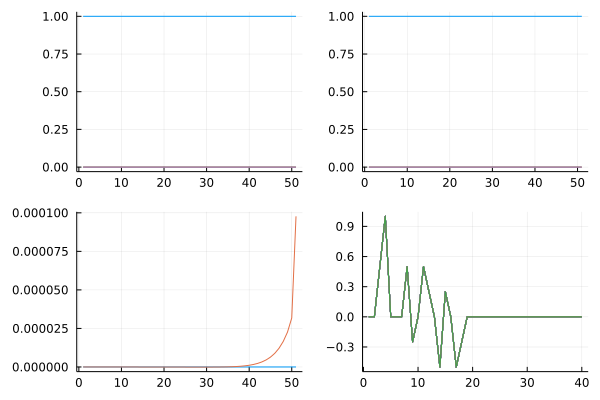

In [15]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0; 0.0; 0.0; 0.0]
    currX = SVector{n, Float64}([q; zeros(18)])
    println(currX[20:22])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    ujump = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    
    N = 51
    dt = 0.02
    mSteps = 51
    modeList = bin_mode_list(N, mSteps)
    
    Q = 100.0 * Diagonal(SVector{n, Float64}([ones(3); 200*ones(4); ones(33)]))
    Qf = 100.0 * Diagonal(SVector{n, Float64}([ones(3); 200*ones(4); ones(33)]))
    R = 0.1 * Diagonal(SVector{m, Float64}([ones(24); 0.01*ones(3)]))
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    uRefSimp = zeros(m, N)
    
    zInds = 3 * [1, 2, 3, 4] .+ 7
    
    for i = 2:N
        xRefSimp[:, i] .= currX
        uRefSimp[:, i] .= ueq
    end
    # q = UnitQuaternion(xRefSimp[4:7, end-1], true)
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(uRefSimp[:, i]) for i = 1:N-1]
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, currX, ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, currX, quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    
    # Stance constraints
    feetStance = [1, 2]
    feetAir = [3, 4]
    stnc = stance_constraints_quad(model, feetStance)
    flgt = flight_constraints_quad(model, feetAir)
    normal = normal_constraints_quad(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    
    p1 = plot(solveX, inds=4:7)
    p2 = plot(XRefSimp, inds=4:7)
    p3 = plot(solveX, inds=21:22)
    p4 = plot(xRefSimp, inds=21:22)
    # println(solveU)
    visualize!(vis, solveX, dt)
    plot(p1, p2, p3, p4, layout = (2, 2), legend=false)
end

## LQR from balancing

In [61]:
begin
    sign(randn())
end

1.0

[-0.23785748706060866, -0.5373391242550014]
[0.062142512939391326, -0.2373391242550014]
[0.06064251293939157, -0.23883912425500248, 0.37, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.913163135983691, -0.2294781677432685, 0.6777563349437852, 0.7888781101049087]
[0.062142512939391326, -0.2373391242550014, 0.37, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.9146631359837017, -0.22797816774326782, 0.6777563349437852, 0.7903781101049191]
Mass of body:11.832

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 58
    Solve Time: 72118.8333 (ms)

  Covergence
    Terminal Cost: 5642.222023997079
    Terminal dJ: 5.043965757067781e-6
    Terminal gradient: 0.00010771701946168943
    Terminal constraint violation: 0.006168607929960666
    Solve Status: SOLVE_SUCCEEDED


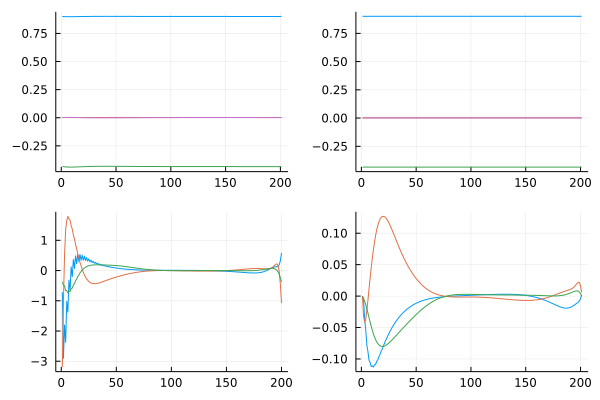

In [120]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.062142512939391326, -0.2373391242550014, 0.37, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.9146631359837017, -0.22797816774326782, 1.1877563349437852, 0.7903781101049191, 0.24670008076673505, 1.2108476539012663, 0.058889234675916634, 0.11007925416261803, -0.0003152360138847866, -0.07190332587837367, -0.25498675884574945, -5.502475941417722e-5, 0.0, 0.0, 0.0, 0.36022785390785483, -0.008708424128853554, -0.5470976042513593, 0.0021666050474541277, -0.0256546109594554, -0.008930028366634816, 0.0283110683324746, -0.0011326659949192877, -0.05118442198200818, 0.028004376983391144, -0.0014028781813309303, -0.005646695047655677, 0.004930035428979808, -0.0016573413396886486, -0.0573735993650161, 0.006168607929960666, -0.0013216010885754555, -0.00761366559341164]
    q[10] = q[10] - 0.51
    q[13] = q[13] - 0.51
    qf = copy(q)
    # println((q[8:9] .- q[11:12]) ./ 2)
    deviation = 0.3
    deviationVec = [deviation; deviation] .* [sign(randn()); sign(randn())]
    q[1:2] = q[1:2] .+ deviationVec
    q[8:9] = deviationVec .+ q[8:9]
    q[11:12] = deviationVec .+ q[11:12]
    println(q[1:2])
    println(qf[1:2])
    ueq = SVector{m, Float64}([-5.51695724431207, 0.173402258116979, 57.411439510247405, 0.0, 0.0, 0.0, -5.579559798294699, 0.18594620641392035, 56.14933789803426, 0.0, 0.0, 0.0, 8.294305500404619, -2.514141458229032, -2.311549415074905, 8.536765803018643, -2.5956497006048562, 0.0, 4.248545918240839, -1.086333173932051, -4.688454786246826, 4.551919658806096, -1.1513296121405796, 0.0, 0.0, 0.0, 0.0])
    currX = SVector{n, Float64}(q)
    termX = SVector{n, Float64}(qf)
    # ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    # ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    # ujump = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    
    N = 201
    dt = 0.01
    mSteps = N
    modeList = bin_mode_list(N, mSteps)
    
    uScale = 5.0
    
    Q = 100.0 * Diagonal(SVector{n, Float64}([100*ones(3); 200*ones(4); ones(12); uScale*ones(3); ones(18)]))
    Qf = 100.0 * Diagonal(SVector{n, Float64}([100*ones(3); 200*ones(4); ones(12); uScale*ones(3); ones(18)]))
    R = 0.1 * Diagonal(SVector{m, Float64}([ones(24); uScale*ones(3)]))
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    uRefSimp = zeros(m, N)
    
    zInds = 3 * [1, 2, 3, 4] .+ 7
    ωs = [0; 0; pi / mSteps]
    
    for i = 2:N
        xRefSimp[:, i] .= xRefSimp[:, i-1]
        xRefSimp[1:2, i] .= xRefSimp[1:2, i] .- deviationVec ./ (N-1)
        xRefSimp[8:9, i] .= xRefSimp[8:9, i] .- deviationVec  ./ (N-1)
        xRefSimp[11:12, i] .= xRefSimp[11:12, i] .- deviationVec  ./ (N-1)
        uRefSimp[:, i] .= ueq
    end
    xRefSimp[:, end] .= termX
    println(xRefSimp[1:11, end-1])
    println(xRefSimp[1:11, end])
    # q = UnitQuaternion(xRefSimp[4:7, end-1], true)
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(uRefSimp[:, i]) for i = 1:N-1]
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, currX, ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, termX, quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    
    # Stance constraints
    feetStance = [1, 2]
    feetAir = [3, 4]
    stnc = stance_constraints_quad(model, feetAir)
    flgt = flight_constraints_quad(model, feetStance)
    normal = normal_constraints_quad(model)
    torque = flywheel_torque_constraints(model)
    angMom = flywheel_momentum_constraints(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    # Add the torque constraints to the system
    for i = 1:N-1
        add_constraint!(conSet, flywheel[1], i)
        add_constraint!(conSet, flywheel[2], i)
        add_constraint!(conSet, flywheel[3], i)
        add_constraint!(conSet, angMom[1], i)
        add_constraint!(conSet, angMom[2], i)
        add_constraint!(conSet, angMom[3], i)
    end
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    println("Mass of body:", mh)
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)

    p1 = plot(solveX, inds=4:7)
    p2 = plot(XRefSimp, inds=4:7)
    p3 = plot(solveU, inds=25:27)
    p4 = plot(solveX, inds=20:22)
    # println(solveU)
    visualize!(vis, solveX, dt)
    plot(p1, p2, p3, p4, layout = (2, 2), legend=false)
end

## Jump straight up

In [9]:
begin
    x = 5
    x += 6
    println(x)
end

11



SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 16
    Solve Time: 6750.723298999999 (ms)

  Covergence
    Terminal Cost: 1043.0887175034595
    Terminal dJ: 9.531232535664458e-6
    Terminal gradient: 10.667416801721725
    Terminal constraint violation: 1.5753485562253026e-6
    Solve Status: SOLVE_SUCCEEDED


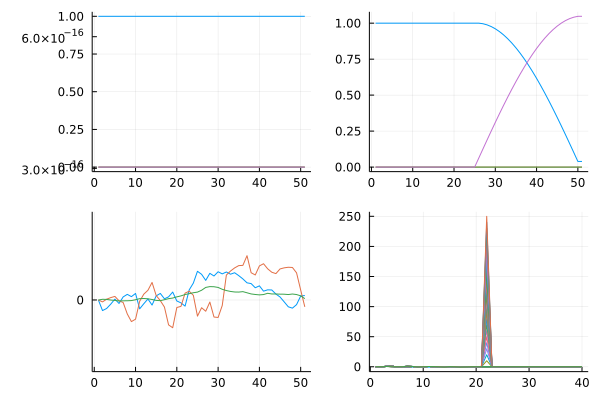

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\brand\.julia\packages\PlotUtils\ebPq2\src\ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\brand\.julia\packages\PlotUtils\ebPq2\src\ticks.jl:295


In [88]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0; 0.0; 0.0; 0.0]
    currX = SVector{n, Float64}([q; zeros(18)])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    ujump = SVector{m, Float64}([ftF; ftF; ftF; ftF; zeros(2); 10.0])
    
    N = 51
    dt = 0.02
    mSteps = 25
    modeList = bin_mode_list(N, mSteps)
    
    Q = 100.0 * Diagonal(SVector{n, Float64}([ones(3); 5*ones(4); ones(33)]))
    Qf = 100.0 * Diagonal(SVector{n, Float64}([ones(3); 5*ones(4); ones(33)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    uRefSimp = zeros(m, N)
    
    zInds = 3 * [1, 2, 3, 4] .+ 7
    ωs = [0; 0; pi / mSteps]
    
    for i = 2:N
        xRefSimp[:, i] .= currX
        uRefSimp[:, i] .= ueq
        if modeList[i] == 2
            xRefSimp[3, i] = .75
            xRefSimp[zInds, i] .= 0.25
            xRefSimp[28, i] = ωs[3]
            xRefSimp[22, i] = xRefSimp[22, i-1] + 10.0
            q = UnitQuaternion(xRefSimp[4:7, i-1], true)
            xRefSimp[4:7, i] .= xRefSimp[4:7, i-1] .+ Rotations.kinematics(q, ωs)
            xRefSimp[8:10] .= [-l/2; w/2; 0.0]
            xRefSimp[11:13] .= [-l/2; -w/2; 0.0]
            xRefSimp[14:16] .= [l/2; w/2; 0.0]
            xRefSimp[17:19] .= [l/2; -w/2; 0.0]
            uRefSimp[:, i] .= ujump
        end
    end
    # q = UnitQuaternion(xRefSimp[4:7, end-1], true)
    xRefSimp[4:7, end] .= xRefSimp[4:7, end-1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(uRefSimp[:, i]) for i = 1:N-1]
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, currX, ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, currX, quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    
    # Stance constraints
    feet = [1, 2, 3, 4]
    stnc = stance_constraints_quad(model, feet)
    flgt = flight_constraints_quad(model, feet)
    normal = normal_constraints_quad(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=4:7)
    p2 = plot(XRefSimp, inds=4:7)
    p3 = plot(solveX, inds=20:22)
    p4 = plot(xRefSimp, inds=20:22)
    # println(solveU)
    
    visualize!(vis, solveX, dt)
    # println(solveX[20][20:22])
    plot(p1, p2, p3, p4, layout = (2, 2), legend=false)
end

## Simple Gait
Walk forward

In [ ]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0]
    currX = SVector{n, Float64}([q; zeros(18)])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF])
    
    N = 201
    dt = 0.01
    mSteps = 50
    modeList = bin_mode_list(N, mSteps)
    
    dx = 0.005
    dbx = 0.002
    dz = 0.0025
    
    Q = 250.0 * Diagonal(SVector{n, Float64}([1.0; 1.0; 5.0; 2*ones(4); 0.1*ones(30)]))
    Qf = 50.0 * Diagonal(SVector{n, Float64}([ones(3); ones(4); ones(30)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    
    triangleStep = triangle_step(dz, mSteps)
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    zInds = 3 * [1, 2, 3, 4] .+ 7
    xInds = [1, 8, 11, 14, 17]
    
    
    # consInds = [2:7, 9:10, 12:13, 18:n]
    smallCount = 1
    for i = 2:N
        xRefSimp[1, i] = xRefSimp[1, i-1] + dbx
        xRefSimp[8, i] = xRefSimp[8, i-1] + dx
        xRefSimp[11, i] = xRefSimp[11, i-1] + dx
        xRefSimp[14, i] = xRefSimp[14, i-1] + dx
        xRefSimp[17, i] = xRefSimp[17, i-1] + dx
        xRefSimp[20, i] = dbx
        xRefSimp[26, i] = dx
        xRefSimp[29, i] = dx
        xRefSimp[32, i] = dx
        xRefSimp[35, i] = dx
        xRefSimp[2:7, i] .= currX[2:7]
        xRefSimp[9:10, i] .= currX[9:10]
        xRefSimp[12:13, i] .= currX[12:13]
        xRefSimp[18:n, i] .= currX[18:n]
        if modeList[i] != modeList[i-1]
            smallCount = 1
        end
        if modeList[i] == 2
            xRefSimp[zInds[3], i] = triangleStep[smallCount]
            xRefSimp[zInds[1], i] = triangleStep[smallCount]
            if smallCount <= mSteps/2 + 1 
                xRefSimp[zInds[3] + 18, i] = dz
                xRefSimp[zInds[1] + 18, i] = dz
            else
                xRefSimp[zInds[3] + 18, i] = -dz
                xRefSimp[zInds[1] + 18, i] = -dz
            end
            xRefSimp[zInds[4], i] = 0.0
            xRefSimp[zInds[2], i] = 0.0
            smallCount += 1
        else
            xRefSimp[zInds[4], i] = triangleStep[smallCount]
            xRefSimp[zInds[2], i] = triangleStep[smallCount]
            if smallCount <= mSteps/2 + 1 
                xRefSimp[zInds[4] + 18, i] = dz
                xRefSimp[zInds[2] + 18, i] = dz
            else
                xRefSimp[zInds[4] + 18, i] = -dz
                xRefSimp[zInds[2] + 18, i] = -dz
            end         
            xRefSimp[zInds[3], i] = 0.0
            xRefSimp[zInds[1], i] = 0.0
            smallCount += 1
        end
        # println(littleCount)
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[end], quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    
    # Stance constraints
    feetL = [1, 3]
    feetR = [2, 4]
    stncL = stance_constraints_quad(model, feetL)
    stncR = stance_constraints_quad(model, feetR)
    flgtL = flight_constraints_quad(model, feetL)
    flgtR = flight_constraints_quad(model, feetR) 
    normal = normal_constraints_quad(model)
    
    # Need to add constraints here because of the gait stuff.
    # Simply alternate every 10 steps
    for i = 2:(length(modeList)-2)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stncL, i)
            add_constraint!(conSet, flgtR, i)
        else
            add_constraint!(conSet, stncR, i)
            add_constraint!(conSet, flgtL, i)
        end
    end
    lastTs = length(modeList) - 1
    add_constraint!(conSet, stncR, lastTs)
    add_constraint!(conSet, stncL, lastTs)
    println("Setting up problem")
    # add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    println("Initializing solver")
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:3)
    p2 = plot(XRefSimp, inds=11:13)

    # println(solveU)
    FileIO.save("fourwalk.jld2","fourwalk",solveU)
    visualize!(vis, solveX, dt)
    println(solveX[end])
    plot(p1, p2, layout = (1, 2), legend=true)
end

## Standing up on hind legs

In [ ]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0]
    currX = SVector{n, Float64}([q; zeros(18)])
    currX = [0.4083337484474368, -0.006871467499115796, 0.45500444707957294, 0.9999991924616065, -0.0005403582151322023, -0.0010145926216593901, 0.0004003166944376557, 1.0601324357482154, -0.2283774795114139, -0.004746529411945324, 0.9358858716135549, 0.245962076812318, -9.120079293371057e-5, 0.05883967913968089, 0.11009658617938874, -0.005146941038089718, -0.07196657014910479, -0.2549728620716495, -0.00011152042860196914, 0.053382476410902435, 0.01294739100556043, -0.7091852828099122, 0.0034650790168831045, 0.021302133374259853, -0.0034741227457854517, 0.006001529365218834, -0.0008349696700663367, -0.057094142717184264, 0.006261200537331771, -0.0007791610340082583, -0.01498874058856626, 0.0057856401396335555, -0.001917822703155901, -0.06657179478523836, 0.006627823038234022, -0.0014375393740754725, -0.018479119393552016]
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF])
    
    N = 61
    dt = 0.01
    mSteps = N
    modeList = bin_mode_list(N, mSteps)
    
    
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    dz = 0.03/2
    dfz = 0.1/2
    dx = -0.01/2
    
    zInds = 3 * [1, 2, 3, 4] .+ 7
    xInds = [1, 8, 11, 14, 17]
    for i = 2:N
        xRefSimp[:, i] .= xRefSimp[:, i-1]  
        xRefSimp[1, i] += dx # shift COM
        xRefSimp[3, i] += dz # shift COM
        xRefSimp[xInds[2], i] += dx # shift COM
        xRefSimp[xInds[3], i] += dx # shift COM
        xRefSimp[zInds[1], i] += dfz
        xRefSimp[zInds[2], i] += dfz
        xRefSimp[6, i] -= 0.01
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    Q = 500.0 * Diagonal(SVector{n, Float64}([5.0; 5.0; 5.0; 20*ones(4); ones(30)]))
    Qf = 250.0 * Diagonal(SVector{n, Float64}([ones(3); 10*ones(4); ones(30)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[end], quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    
    # Stance constraints
    feetL = [1, 2]
    feetR = [3, 4]
    stncR = stance_constraints_quad(model, feetR)
    flgtL = flight_constraints_quad(model, feetL)
    normal = normal_constraints_quad(model)
    
    # Need to add constraints here because of the gait stuff.
    # Simply alternate every 10 steps
    add_constraint!(conSet, stncR, 1)
    add_constraint!(conSet, stance_constraints_quad(model, feetL), 1)
    for i = 2:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        add_constraint!(conSet, stncR, i)
        add_constraint!(conSet, flgtL, i)
    end
    println("Setting up problem")
    # add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    println("Initializing solver")
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:3)
    p2 = plot(XRefSimp, inds=1:3)

    # println(solveU)
    visualize!(vis, solveX, dt)
    println(solveX[end])
    println(solveU[end])
    FileIO.save("riseup.jld2","riseup",solveU)
    plot(p1, p2, layout = (1, 2), legend=true)
end

## Balancing on high legs

In [ ]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    currX = SVector{n, Float64}([-0.35721884755799185, 1.2421933522512236e-18, 1.1141632473395322, 0.902421703494208, -1.518471840577485e-20, -0.43083184195052643, -1.770321747190079e-18, 0.33077871988393337, -0.25, 1.2086388401222523, 0.3307787198839333, 0.25, 1.2086388401222519, -0.49999385201872987, 0.25, -0.0002255808523900592, -0.49999385201872987, -0.25, -0.00022558085239005892, 0.3818590009032497, -1.0291472031890295e-18, 0.024029168891855784, -9.128417933616232e-17, -0.04947924150753177, -2.7409597343700735e-18, 0.04423727379758401, -9.74404516985685e-20, 0.00217532011183182, 0.044237273797583986, -4.695137798950326e-20, 0.0021753201118313763, 0.00021249751105352756, 4.908658187610777e-19, 0.0049039609983264785, 0.0002124975110535322, 4.902636397957402e-19, 0.004903960998326517])
    ueq = SVector{m, Float64}([-3.605878492627672, 3.1574892117674853e-17, 47.30978832707465, -2.3407271255208595e-12, -7.256972367520846e-25, -2.554731143050629e-13, -3.605878492627674, 1.430535398087711e-16, 47.30978832707466, -2.3407270789366323e-12, -7.256976861092975e-25, -2.55473083511817e-13, -1.1423756056519905, -2.474390168768979e-15, -3.9457112991543073, -1.1320935086955624, -2.4507586532911102e-15, 7.394414286880654, -1.142375605651992, -2.4691226458921895e-15, -3.945711299154313, -1.1320935086955637, -2.4455202681156226e-15, 7.394414286880652])
    
    N = 51
    dt = 0.01
    mSteps = N
    modeList = bin_mode_list(N, mSteps)
    
    Q = 250.0 * Diagonal(SVector{n, Float64}([5.0; 5.0; 5.0; 20*ones(4); ones(30)]))
    Qf = 50.0 * Diagonal(SVector{n, Float64}([ones(3); ones(4); 5*ones(30)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    dz = 0.05
    for i = 2:N
        xRefSimp[:, i] .= currX
#         if i <= N/2 + 1
#             xRefSimp[16, i] = xRefSimp[16, i-1] + dz
#         else
#             xRefSimp[16, i] = xRefSimp[16, i-1] - dz
#         end
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[end], quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    feetL = [1, 2]
    feetRB = [3, 4]
    feetLB = 3
    stncR = stance_constraints_quad(model, feetRB)
    flgtL = flight_constraints_quad(model, feetL)
    # flgtLB = flight_constraints_quad(model, feetLB)
    normal = normal_constraints_quad(model)
    
    add_constraint!(conSet, stncR, 1)
#     add_constraint!(conSet, flgtL, 1)
#     add_constraint!(conSet, normal, 1)
    for i = 2:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        add_constraint!(conSet, stncR, i)
        add_constraint!(conSet, flgtL, i)
        # add_constraint!(conSet, flgtLB, i)
    end
    println("Setting up problem")
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    println("Initializing solver")
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:3)
    p2 = plot(XRefSimp, inds=1:3)

    # println(solveU)
    visualize!(vis, solveX, dt)
    println(solveX[end])
    println(solveU[end])
    FileIO.save("balance.jld2","balance",solveU)
    plot(p1, p2, layout = (1, 2), legend=true)
end

## Walking on the hind legs

In [ ]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    refX = [-0.35721884755799185, 2.1444249464638957e-12, 1.149456679740186, 0.8999660405239078, -4.789894101252221e-13, -0.4359344318481529, 1.0118552795585863e-12, 0.2751820216213111, -0.25000000000129424, 1.2187639489966569, 0.2751820216234057, 0.24999999999870556, 1.2187639490002453, -0.5000191007912645, 0.25000000000201594, -0.00026709245879060357, -0.5000191007923315, -0.24999999999798414, -0.0002670924586895826, 0.7767528581555256, -8.524892354169328e-13, -0.37395891387017094, -3.4386094837726094e-14, -0.09395743283701867, -1.5683575112965863e-12, 0.09269118756616619, 6.262909075619228e-13, -0.09163916276105165, 0.09269118756514678, 6.262947507202323e-13, -0.09163916276326001, -0.003772592208573113, -2.2208629965564175e-14, -0.013013476514851213, -0.0037725922085046814, -2.220783573224089e-14, -0.013013476514790576]
    currX = SVector{n, Float64}([refX[1:19]; zeros(18)])
    currX = [0.20710435981216968, -0.01279742315240455, 0.8959605257806459, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.9146631359837017, -0.22797816774326782, 1.1877563349437852, 0.7903781101049191, 0.24670008076673505, 1.2108476539012663, 0.058889234675916634, 0.11007925416261803, -0.0003152360138847866, -0.07190332587837367, -0.25498675884574945, -5.502475941417722e-5, 0.36022785390785483, -0.008708424128853554, -0.5470976042513593, 0.0021666050474541277, -0.0256546109594554, -0.008930028366634816, 0.0283110683324746, -0.0011326659949192877, -0.05118442198200818, 0.028004376983391144, -0.0014028781813309303, -0.005646695047655677, 0.004930035428979808, -0.0016573413396886486, -0.0573735993650161, 0.006168607929960666, -0.0013216010885754555, -0.00761366559341164]
    # currX = [0.4083337484474368, -0.006871467499115796, 0.45500444707957294, 0.9999991924616065, -0.0005403582151322023, -0.0010145926216593901, 0.0004003166944376557, 1.0601324357482154, -0.2283774795114139, -0.004746529411945324, 0.9358858716135549, 0.245962076812318, -9.120079293371057e-5, 0.05883967913968089, 0.11009658617938874, -0.005146941038089718, -0.07196657014910479, -0.2549728620716495, -0.00011152042860196914, 0.053382476410902435, 0.01294739100556043, -0.7091852828099122, 0.0034650790168831045, 0.021302133374259853, -0.0034741227457854517, 0.006001529365218834, -0.0008349696700663367, -0.057094142717184264, 0.006261200537331771, -0.0007791610340082583, -0.01498874058856626, 0.0057856401396335555, -0.001917822703155901, -0.06657179478523836, 0.006627823038234022, -0.0014375393740754725, -0.018479119393552016]

    ueq = SVector{m, Float64}([-0.13062920979526843, 2.647770735061424e-11, -9.00319527824362, -1.1501490820629788e-12, -1.2728761783980477e-22, -2.771812645666031e-13, -0.13062920979231055, 2.648230779451539e-11, -9.003195278374296, -1.1501491640729734e-12, -1.26861978706255e-22, -2.7718130432421204e-13, 9.342530060572683, 3.734619026795296e-12, 42.301660078640005, 9.157913789242901, 2.646405240451352e-12, 52.116897451712624, 9.34253006025715, 3.7347511547775495e-12, 42.30166007901008, 9.157913788930717, 2.6465762351574246e-12, 52.11689745159575])
    
    N = 101
    dt = 0.01
    mSteps = 25    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    countSt = 1
    while countSt < N
        modeList[countSt] = iState
        if mod(countSt, mSteps) == 0
            iState += next
            next *= -1
        end
        countSt += 1
    end
    
    
   
    triangleStep = zeros(mSteps)
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    zInds = 3 * [1, 2, 3, 4] .+ 7
    xInds = [1, 8, 11, 14, 17]
    dx = 0.005
    dbx = 0.0025
    dz = 0.001
    triangleStep[1] = 0.0
    for i = 2:mSteps
        if i <= mSteps/2 + 1
            triangleStep[i] = triangleStep[i-1] + dz
        else
            triangleStep[i] = triangleStep[i-1] - dz
        end
    end
    
    # consInds = [2:7, 9:10, 12:13, 18:n]
    smallCount = 1
    for i = 2:N
        xRefSimp[1, i] = xRefSimp[1, i-1] + dbx
        xRefSimp[8, i] = xRefSimp[8, i-1] + dbx
        xRefSimp[11, i] = xRefSimp[11, i-1] + dbx
        xRefSimp[14, i] = xRefSimp[14, i-1] + dx
        xRefSimp[17, i] = xRefSimp[17, i-1] + dx
        xRefSimp[20, i] = dbx
        xRefSimp[26, i] = dbx
        xRefSimp[29, i] = dbx
        xRefSimp[32, i] = dx
        xRefSimp[35, i] = dx
        xRefSimp[2:7, i] .= currX[2:7]
        xRefSimp[9:10, i] .= currX[9:10]
        xRefSimp[12:13, i] .= currX[12:13]
        xRefSimp[18:n, i] .= currX[18:n]
        if modeList[i] != modeList[i-1]
            smallCount = 1
        end
        if modeList[i] == 2
            xRefSimp[zInds[3], i] = triangleStep[smallCount]
            if smallCount <= mSteps/2 + 1 
                xRefSimp[zInds[3] + 18, i] = dz
            else
                xRefSimp[zInds[3] + 18, i] = -dz
            end
            xRefSimp[zInds[4], i] = 0.0
            smallCount += 1
        else
            xRefSimp[zInds[4], i] = triangleStep[smallCount]
            if smallCount <= mSteps/2 + 1 
                xRefSimp[zInds[4] + 18, i] = dz
            else
                xRefSimp[zInds[4] + 18, i] = -dz
            end
            # xRefSimp[zInds[4] + 18, i] = dz / mStep            
            xRefSimp[zInds[3], i] = 0.0
            smallCount += 1
        end
        # println(littleCount)
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    # decreasing the cost on the zs seems to do well 
    Q = 250.0 * Diagonal(SVector{n, Float64}([5.0; 5.0; 5.0; 10*ones(4); ones(24); 0.05*ones(6)]))
    Qf = 250.0 * Diagonal(SVector{n, Float64}([ones(3); ones(4); ones(30)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    
    
    costs = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], ueq, quat_ind=4:7) for i = 1:N-1]
    costs = [costs; TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[end], quat_ind=4:7)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    feetL = [1, 2]
    backL = 3
    backR = 4
    
    stncR = stance_constraints_quad(model, backR)
    stncL = stance_constraints_quad(model, backL)
    flgtL = flight_constraints_quad(model, backL)
    flgtR = flight_constraints_quad(model, backR)
    flgt = flight_constraints_quad(model, feetL)
    normal = normal_constraints_quad(model)
    
#     add_constraint!(conSet, stncL, 1)
#     add_constraint!(conSet, stncR, 1)
    for i = 2:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        add_constraint!(conSet, flgt, i)
        if modeList[i] == 1
            add_constraint!(conSet, stncL, i)
            add_constraint!(conSet, flgtR, i)
        else
            add_constraint!(conSet, stncR, i)
            add_constraint!(conSet, flgtL, i)
        end
    end
#     add_constraint!(conSet, normal, N-1)
#     add_constraint!(conSet, flgt, N-1)
#     add_constraint!(conSet, stncR, N-1)
#     add_constraint!(conSet, stncL, N-1)
    
    println("Setting up problem")
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    println("Initializing solver")
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=[16,19])
    p2 = plot(XRefSimp, inds=[14, 16, 17, 19])

    # println(solveU)
    FileIO.save("two.jld2","twowalk",solveU)
    visualize!(vis, solveX, dt)
    # println(solveX[end-5:end])
    plot(p1, p2, layout = (1, 2), legend=true)
end

## Full circuit

In [ ]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    
    
    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0]
    currX = SVector{n, Float64}([q; zeros(18)])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    ueq = SVector{m, Float64}([ftF; ftF; ftF; ftF])
    conSet = ConstraintList(n, m, N)
    
    # The indices go 201, 61, and 101
    # The modesteps go 50, 61, and 25
    lengths = [200, 60, 101]
    N = 361
    sTsList = [1, lengths[1] + 1, lengths[1] + lengths[2] + 1]
    lTsList = [lengths[1], lengths[1] + lengths[2], lengths[1] + lengths[2] + lengths[3]]
    modeStepsPerWalk = [50, 61, 25]
    
    dt = 0.01
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    zInds = 3 * [1, 2, 3, 4] .+ 7
    xInds = [1, 8, 11, 14, 17]
    dx = 0.005
    dbx = 0.0025
    
    # Walking on all fours ref traj
    dz = 0.0025
    triangleStep = triangle_step(dz, modeStepsPerWalk[1])
    lastTs = lengths[1]
    modeList = bin_mode_list(lastTs, modeStepsPerWalk[1])
    smallCount = 1
    println(lastTs)
    
    for i = 2:lastTs
        xRefSimp[1, i] = xRefSimp[1, i-1] + dbx
        xRefSimp[8, i] = xRefSimp[8, i-1] + dx
        xRefSimp[11, i] = xRefSimp[11, i-1] + dx
        xRefSimp[14, i] = xRefSimp[14, i-1] + dx
        xRefSimp[17, i] = xRefSimp[17, i-1] + dx
        xRefSimp[20, i] = dbx
        xRefSimp[26, i] = dx
        xRefSimp[29, i] = dx
        xRefSimp[32, i] = dx
        xRefSimp[35, i] = dx
        xRefSimp[2:7, i] .= currX[2:7]
        xRefSimp[9:10, i] .= currX[9:10]
        xRefSimp[12:13, i] .= currX[12:13]
        xRefSimp[18:n, i] .= currX[18:n]
        if modeList[i] != modeList[i-1]
            smallCount = 1
        end
        if modeList[i] == 2
            xRefSimp[zInds[3], i] = triangleStep[smallCount]
            xRefSimp[zInds[1], i] = triangleStep[smallCount]
            if smallCount <= modeStepsPerWalk[1]/2 + 1 
                xRefSimp[zInds[3] + 18, i] = dz
                xRefSimp[zInds[1] + 18, i] = dz
            else
                xRefSimp[zInds[3] + 18, i] = -dz
                xRefSimp[zInds[1] + 18, i] = -dz
            end
            xRefSimp[zInds[4], i] = 0.0
            xRefSimp[zInds[2], i] = 0.0
            smallCount += 1
        else
            xRefSimp[zInds[4], i] = triangleStep[smallCount]
            xRefSimp[zInds[2], i] = triangleStep[smallCount]
            if smallCount <= modeStepsPerWalk[1]/2 + 1 
                xRefSimp[zInds[4] + 18, i] = dz
                xRefSimp[zInds[2] + 18, i] = dz
            else
                xRefSimp[zInds[4] + 18, i] = -dz
                xRefSimp[zInds[2] + 18, i] = -dz
            end         
            xRefSimp[zInds[3], i] = 0.0
            xRefSimp[zInds[1], i] = 0.0
            smallCount += 1
        end
        # println(littleCount)
    end
    
    # Stance constraints
    feetL = [1, 3]
    feetR = [2, 4]
    stncL = stance_constraints_quad(model, feetL)
    stncR = stance_constraints_quad(model, feetR)
    flgtL = flight_constraints_quad(model, feetL)
    flgtR = flight_constraints_quad(model, feetR) 
    normal = normal_constraints_quad(model)
    
    # Constraint adding/solving time
     for i = 2:lastTs-1
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stncL, i)
            add_constraint!(conSet, flgtR, i)
        else
            add_constraint!(conSet, stncR, i)
            add_constraint!(conSet, flgtL, i)
        end
    end
    
    
    ## Standing on the hind legs
    dz = 0.02/2
    dfz = 0.06/2
    dx = -0.01/2
    startTs = lastTs + 1
    lastTs = lastTs + lengths[2]
    println(lastTs - startTs)
    modeList = bin_mode_list(lastTs - startTs + 1, modeStepsPerWalk[2])
    # currX = [0.4083337484474368, -0.006871467499115796, 0.45500444707957294, 0.9999991924616065, -0.0005403582151322023, -0.0010145926216593901, 0.0004003166944376557, 1.0601324357482154, -0.2283774795114139, -0.004746529411945324, 0.9358858716135549, 0.245962076812318, -9.120079293371057e-5, 0.05883967913968089, 0.11009658617938874, -0.005146941038089718, -0.07196657014910479, -0.2549728620716495, -0.00011152042860196914, 0.053382476410902435, 0.01294739100556043, -0.7091852828099122, 0.0034650790168831045, 0.021302133374259853, -0.0034741227457854517, 0.006001529365218834, -0.0008349696700663367, -0.057094142717184264, 0.006261200537331771, -0.0007791610340082583, -0.01498874058856626, 0.0057856401396335555, -0.001917822703155901, -0.06657179478523836, 0.006627823038234022, -0.0014375393740754725, -0.018479119393552016]
    xRefSimp[:, startTs] .= xRefSimp[:, startTs-1]
    for i = startTs:lastTs
        xRefSimp[:, i] .= xRefSimp[:, i-1]  
        xRefSimp[1, i] += dx # shift COM
        xRefSimp[3, i] += dz # shift COM
        xRefSimp[xInds[2], i] += dx # shift COM
        xRefSimp[xInds[3], i] += dx # shift COM
        xRefSimp[zInds[1], i] += dfz
        xRefSimp[zInds[2], i] += dfz
        xRefSimp[6, i] -= 0.01
    end
    
    # Stance constraints
    feetL = [1, 2]
    feetR = [3, 4]
    stncR = stance_constraints_quad(model, feetR)
    flgtL = flight_constraints_quad(model, feetL)
    normal = normal_constraints_quad(model)
    
    add_constraint!(conSet, stncR, startTs)
    add_constraint!(conSet, stance_constraints_quad(model, feetL), startTs)
    for i = startTs+1:lastTs-1
        add_constraint!(conSet, normal, i)
        add_constraint!(conSet, stncR, i)
        add_constraint!(conSet, flgtL, i)
    end
    
    
#     # Walking on hind legs
    dz = 0.001
    dx = 0.01
    dbx = 0.005
    triangleStep = triangle_step(dz, modeStepsPerWalk[3])
    currX = [0.20710435981216968, -0.01279742315240455, 0.8959605257806459, 0.9007877958479696, 0.0020685329430367915, -0.43424174934483767, 0.0013525869717635039, 0.9146631359837017, -0.22797816774326782, 1.1877563349437852, 0.7903781101049191, 0.24670008076673505, 1.2108476539012663, 0.058889234675916634, 0.11007925416261803, -0.0003152360138847866, -0.07190332587837367, -0.25498675884574945, -5.502475941417722e-5, 0.36022785390785483, -0.008708424128853554, -0.5470976042513593, 0.0021666050474541277, -0.0256546109594554, -0.008930028366634816, 0.0283110683324746, -0.0011326659949192877, -0.05118442198200818, 0.028004376983391144, -0.0014028781813309303, -0.005646695047655677, 0.004930035428979808, -0.0016573413396886486, -0.0573735993650161, 0.006168607929960666, -0.0013216010885754555, -0.00761366559341164]
    startTs = lastTs + 1
    lastTs = lastTs + lengths[3]
    modeList = bin_mode_list(lastTs - startTs + 1, modeStepsPerWalk[3])
    xRefSimp[:, startTs] .= currX
    smallCount = 1
    k = 2
    println(lastTs)
    for i = startTs+1:lastTs
        xRefSimp[1, i] = xRefSimp[1, i-1] + dbx
        xRefSimp[8, i] = xRefSimp[8, i-1] + dbx
        xRefSimp[11, i] = xRefSimp[11, i-1] + dbx
        xRefSimp[14, i] = xRefSimp[14, i-1] + dx
        xRefSimp[17, i] = xRefSimp[17, i-1] + dx
        xRefSimp[20, i] = dbx
        xRefSimp[26, i] = dbx
        xRefSimp[29, i] = dbx
        xRefSimp[32, i] = dx
        xRefSimp[35, i] = dx
        xRefSimp[2:7, i] .= currX[2:7]
        xRefSimp[9:10, i] .= currX[9:10]
        xRefSimp[12:13, i] .= currX[12:13]
        xRefSimp[18:n, i] .= currX[18:n]
        if modeList[k] != modeList[k-1]
            smallCount = 1
        end
        if modeList[i-startTs+1] == 2
            xRefSimp[zInds[3], i] = triangleStep[smallCount]
            if smallCount <= modeStepsPerWalk[3]/2 + 1 
                xRefSimp[zInds[3] + 18, i] = dz
            else
                xRefSimp[zInds[3] + 18, i] = -dz
            end
            xRefSimp[zInds[4], i] = 0.0
            smallCount += 1
        else
            xRefSimp[zInds[4], i] = triangleStep[smallCount]
            if smallCount <= modeStepsPerWalk[3]/2 + 1 
                xRefSimp[zInds[4] + 18, i] = dz
            else
                xRefSimp[zInds[4] + 18, i] = -dz
            end
            # xRefSimp[zInds[4] + 18, i] = dz / mStep            
            xRefSimp[zInds[3], i] = 0.0
            smallCount += 1
        end
        k += 1
        # println(littleCount)
    end
    
    # Stance constraints
    feetL = [1, 2]
    backL = 3
    backR = 4
    
    stncR = stance_constraints_quad(model, backR)
    stncL = stance_constraints_quad(model, backL)
    flgtL = flight_constraints_quad(model, backL)
    flgtR = flight_constraints_quad(model, backR)
    flgt = flight_constraints_quad(model, feetL)
    normal = normal_constraints_quad(model)

    for i = startTs+1:lastTs-1
        add_constraint!(conSet, normal, i)
        add_constraint!(conSet, flgt, i)
        if modeList[i-startTs] == 1
            add_constraint!(conSet, stncL, i)
            add_constraint!(conSet, flgtR, i)
        else
            add_constraint!(conSet, stncR, i)
            add_constraint!(conSet, flgtL, i)
        end
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N]
    
    println(length(URefSimp))
    # URefSimp = [SVector{m}(uRefSimp) for i = 1:N]
    # Quad costs
    Q = 100.0 * Diagonal(SVector{n, Float64}([1.0; 1.0; 5.0; 2*ones(4); ones(30)]))
    Qf = 150.0 * Diagonal(SVector{n, Float64}([ones(3); ones(4); ones(30)]))
    quadCosts = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], URefSimp[i], quat_ind=4:7) for i = 1:lengths[1]]
    # quadCosts = [quadCosts; TrajectoryOptimization.QuatLQRCost(Qf, R, XRefSimp[lTsList[1]], quat_ind=4:7)]
    
    # Standin up cost
    Q = 250.0 * Diagonal(SVector{n, Float64}([5.0; 5.0; 5.0; 20*ones(4); 0.1*ones(30)]))
    Qf = 350.0 * Diagonal(SVector{n, Float64}([5*ones(3); 5*ones(4); ones(30)]))
    standCosts = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], URefSimp[i], quat_ind=4:7) for i = sTsList[2]:lTsList[2]]
    # standCosts = [standCosts; TrajectoryOptimization.QuatLQRCost(Qf, R, XRefSimp[lTsList[2]], quat_ind=4:7)]
    
#     # Hind Legs
    Q = 250.0 * Diagonal(SVector{n, Float64}([5.0; 5.0; 5.0; 10*ones(4); ones(24); 0.05*ones(6)]))
    Qf = 250.0 * Diagonal(SVector{n, Float64}([ones(3); ones(4); ones(30)]))
    R = 0.1 * Diagonal(SVector{m, Float64}(ones(m)))
    println(sTsList[3])
    twoLegCosts = [TrajectoryOptimization.QuatLQRCost(Q, R, XRefSimp[i], URefSimp[i], quat_ind=4:7) for i = sTsList[3]:lTsList[3]-1]
    twoLegCosts = [twoLegCosts; TrajectoryOptimization.QuatLQRCost(Qf, R, XRefSimp[end], quat_ind=4:7)]
    println("starting costs concats")
    
    costs = [quadCosts; standCosts; twoLegCosts]
    obj = Objective(costs)
    
    println("Setting up problem")
    
    prob = Problem(model, obj, XRefSimp[end], N*dt, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    # rollout!(prob)
    
    println("Initializing solver")
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
   

    # println(solveU)
    visualize!(vis, solveX, dt)
    plot(XRefSimp, inds=8:13)
    # plot(solveX, inds=8:13)
end